In [1]:
import sys
import os

# Add the parent directory of 'station_focus' to sys.path
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Parent directory
sys.path.append(base_path)
file_path = os.path.join(base_path, "data/boston/bike_trip_focused_data.parquet")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src import data_processing as dp
from src import utils
import geopandas as gpd

import seaborn as sns
from sklearn.ensemble import IsolationForest

from datetime import datetime


In [2]:
# dp.bike_trip_process_data_and_save(city_name = 'boston', start = datetime(2023, 1, 1), end = datetime(2023, 1, 31), pca=False)

In [3]:
station_data = dp.from_trip_to_station_focused(file_path)

In [4]:
station_data.columns

Index(['station_id', 'hour', 'day', 'month', 'is_start', 'count',
       'tripduration_mean', 'tripduration_std', 'tripduration_median',
       'distance_mean', 'distance_std', 'distance_median', 'speed_mean',
       'speed_std', 'speed_median', 'user_type_encoded_mean', 'temp_mean',
       'prcp_mean', 'wspd_mean', 'coco_mean', 'station_name', 'neighborhood',
       'geometry', 'nearby_transit_stops', 'dayofweek', 'is_weekend',
       'special_day'],
      dtype='object')

# Temporal Analysis


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



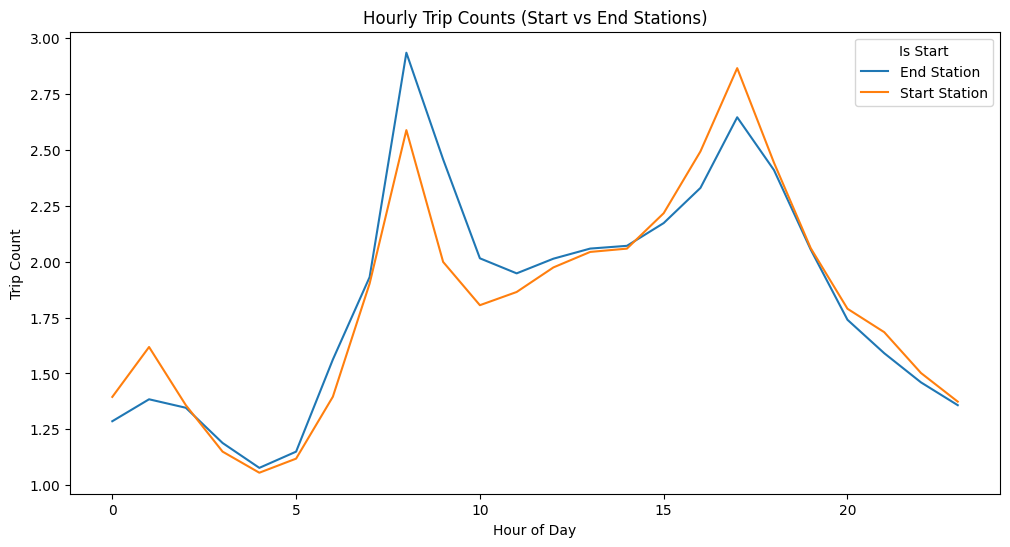

In [11]:
# Hourly analysis of trip counts
plt.figure(figsize=(12, 6))
sns.lineplot(data=station_data, x='hour', y='count', hue='is_start', ci=None)
plt.title('Hourly Trip Counts (Start vs End Stations)')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
plt.legend(title="Is Start", labels=["End Station", "Start Station"])
plt.show()


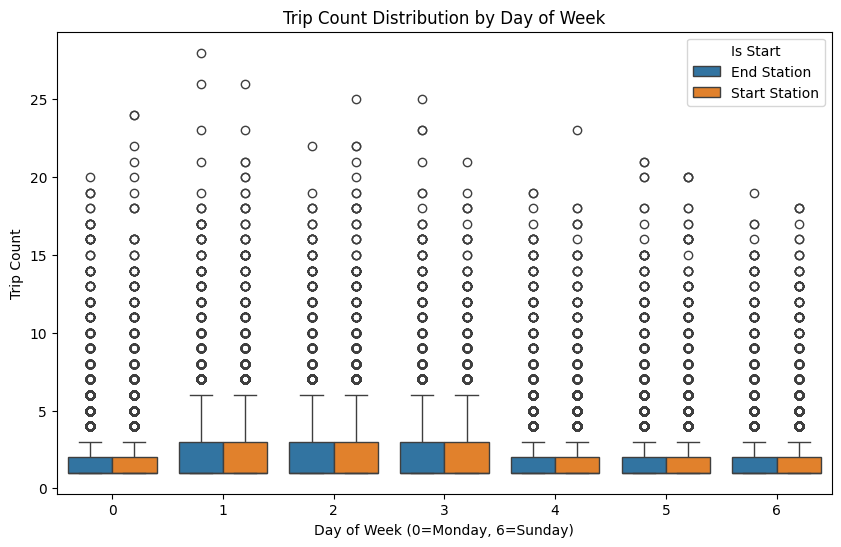

In [12]:
# Day-of-week analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=station_data, x='dayofweek', y='count', hue='is_start')
plt.title('Trip Count Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Trip Count')
# Get the handles and labels from the plot
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


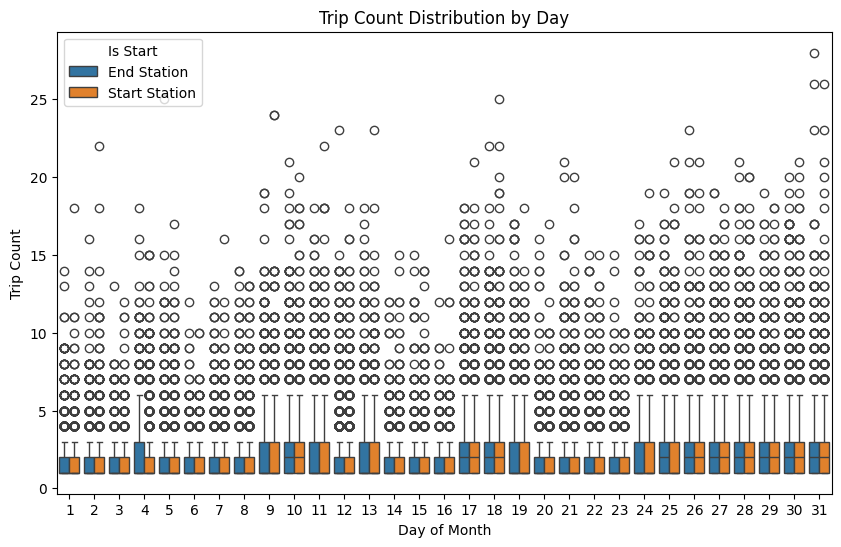

In [13]:
# Day-of-week analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=station_data, x='day', y='count', hue='is_start')
plt.title('Trip Count Distribution by Day')
plt.xlabel('Day of Month')
plt.ylabel('Trip Count')
# Get the handles and labels from the plot
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


# Station-Specific Analysis

Top 10 Stations by Total Trip Count:
station_name
MIT at Mass Ave / Amherst St                   6807
Central Square at Mass Ave / Essex St          6160
MIT Vassar St                                  3977
Harvard Square at Mass Ave/ Dunster            3926
MIT Pacific St at Purrington St                3896
Forsyth St at Huntington Ave                   3339
Boylston St at Massachusetts Ave               3105
MIT Stata Center at Vassar St / Main St        3038
Charles Circle - Charles St at Cambridge St    2858
Mass Ave at Albany St                          2840
Name: count, dtype: int64

Bottom 10 Stations by Total Trip Count:
station_name
Community Life Center         1
Auburndale                    3
Cleary Sq                     3
Goodhue St at Grove St        3
Newton Library                4
Ross Playground               4
Blue Hill Ave at Almont St    5
Hyde Park Library             6
Langley Lot                   6
Beacon at Walnut              7
Name: count, dtype: int64


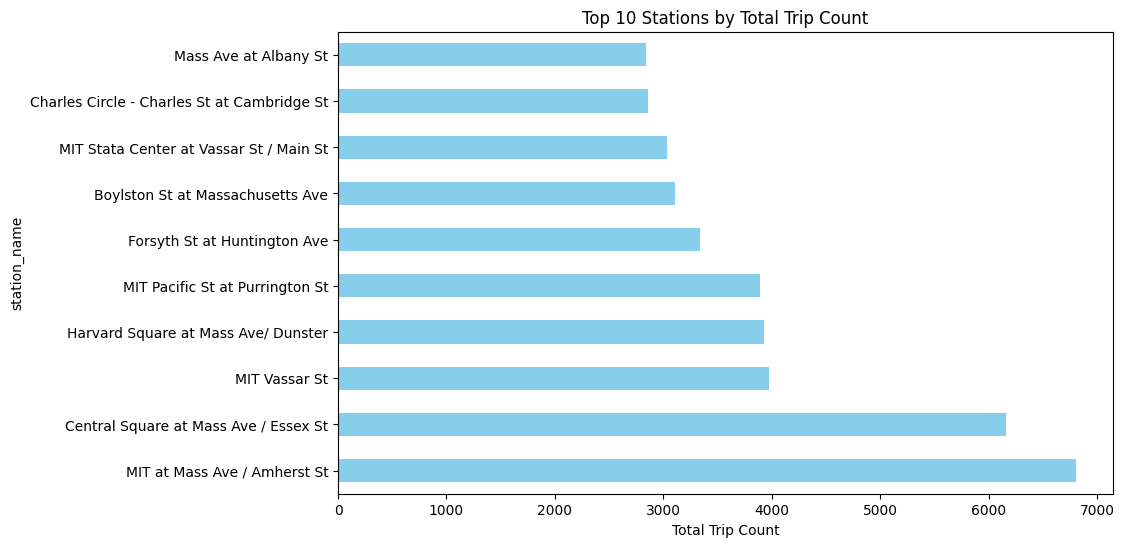

In [14]:
# Total counts by station
top_stations = station_data.groupby('station_name')['count'].sum().nlargest(10)
bottom_stations = station_data.groupby('station_name')['count'].sum().nsmallest(10)

print("Top 10 Stations by Total Trip Count:")
print(top_stations)

print("\nBottom 10 Stations by Total Trip Count:")
print(bottom_stations)

# Visualize top stations
top_stations.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Stations by Total Trip Count')
plt.xlabel('Total Trip Count')
plt.show()


# Weather Impact

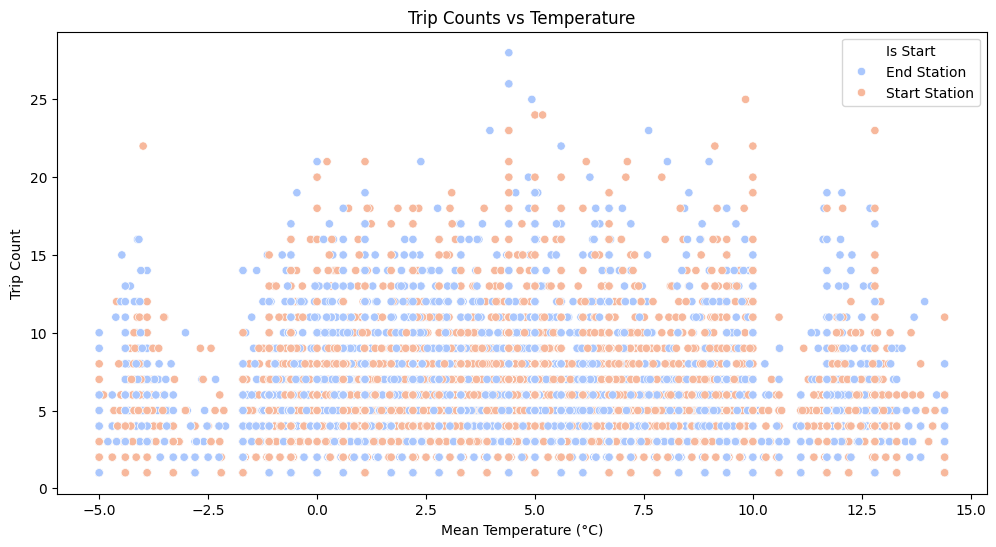

In [16]:
# Relationship between temperature and trip counts
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=station_data, x='temp_mean', y='count', hue='is_start', palette='coolwarm')
plt.title('Trip Counts vs Temperature')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


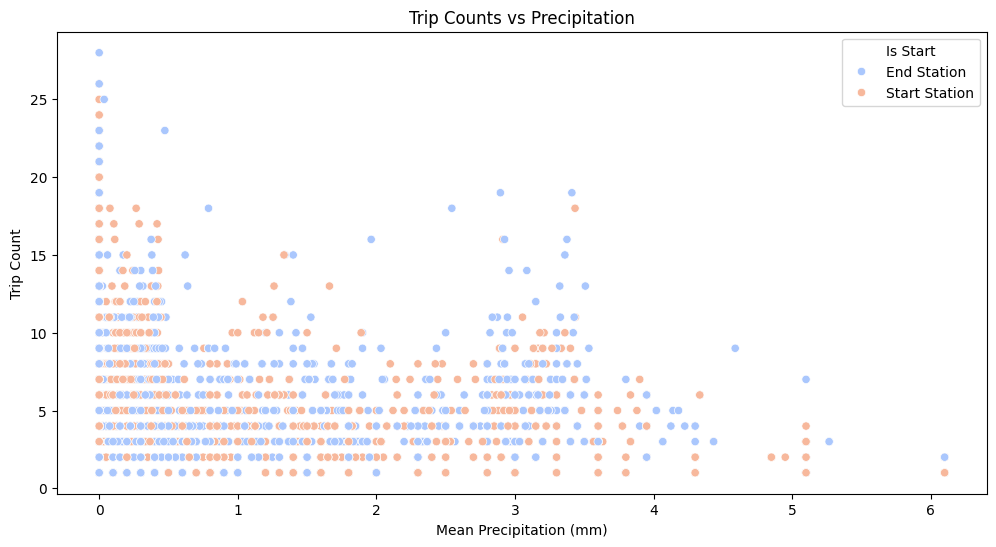

In [17]:
# Precipitation vs trip counts
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=station_data, x='prcp_mean', y='count', hue='is_start', palette='coolwarm')
plt.title('Trip Counts vs Precipitation')
plt.xlabel('Mean Precipitation (mm)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


# Anomaly Analysis

In [39]:
# Select relevant features
features = [
    'count',                 # Core usage metric
    'distance_mean',         # Average trip distance
    'tripduration_mean',     # Average trip duration
    'speed_mean',            # Average trip speed
    'temp_mean',             # Weather impact
    'prcp_mean',             # Weather impact
    'wspd_mean',             # Weather impact
    'hour',                  # Temporal variation
    'day',
    'dayofweek',             # Temporal variation
    'nearby_transit_stops',   # Station context
    'user_type_encoded_mean',
    'coco_mean',             
    'is_weekend',
    'neighborhood'
]
# features = ['station_id', 'hour', 'day', 'month', 'is_start', 'count',
#        'tripduration_mean', 'tripduration_std', 'tripduration_median',
#        'distance_mean', 'distance_std', 'distance_median', 'speed_mean',
#        'speed_std', 'speed_median', 'user_type_encoded_mean', 'temp_mean',
#        'prcp_mean', 'wspd_mean', 'coco_mean', 'station_name', 'neighborhood',
#        'geometry', 'nearby_transit_stops', 'dayofweek', 'is_weekend',
#        'special_day']
anomaly_data = station_data[features].fillna(0)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
station_data['anomaly'] = iso_forest.fit_predict(anomaly_data)

# Analyze anomalies
anomalies = station_data[station_data['anomaly'] == -1]
print("Anomalies Detected:")
print(anomalies)


Anomalies Detected:
        station_id  hour  day  month  is_start  count  tripduration_mean  \
19               1    15   28      1         0      1            86016.0   
20               1    20   30      1         0      1            61813.0   
45               3     7    1      1         0      1             7353.0   
479              4     1    1      1         1      4             1659.0   
1098             4    23   28      1         1      1            48437.0   
...            ...   ...  ...    ...       ...    ...                ...   
134159         591     1    1      1         1      1              944.0   
134167         591     2   15      1         0      1             2123.0   
134187         591     8    5      1         0      1            76048.0   
134269         591    11    4      1         1      1            76048.0   
134541         591    20    3      1         1      1            32707.0   

        tripduration_std  tripduration_median  distance_mean  ...  

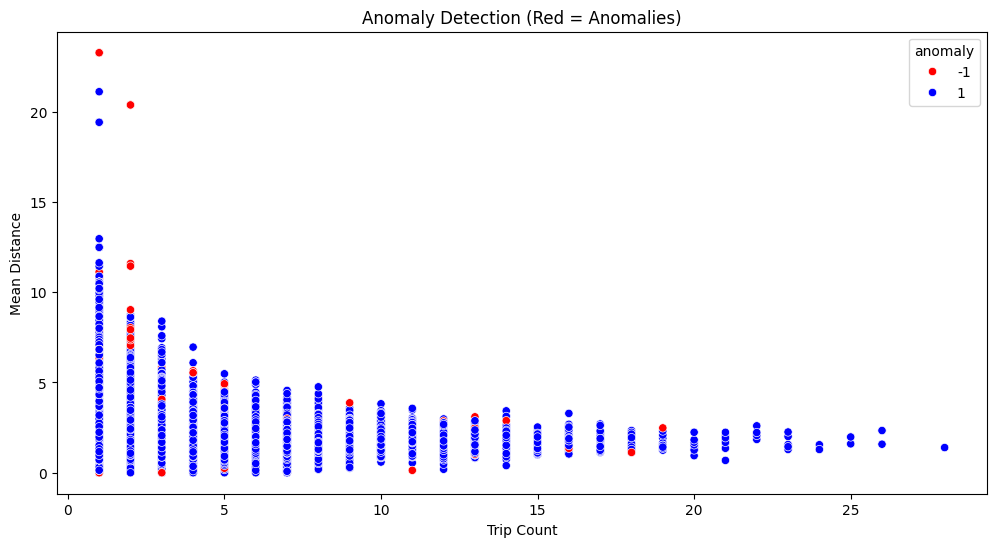

In [40]:
# Visualize anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(data=station_data, x='count', y='distance_mean', hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Anomaly Detection (Red = Anomalies)')
plt.xlabel('Trip Count')
plt.ylabel('Mean Distance')
plt.show()


## Pair Plot (Multi-Dimensional View)

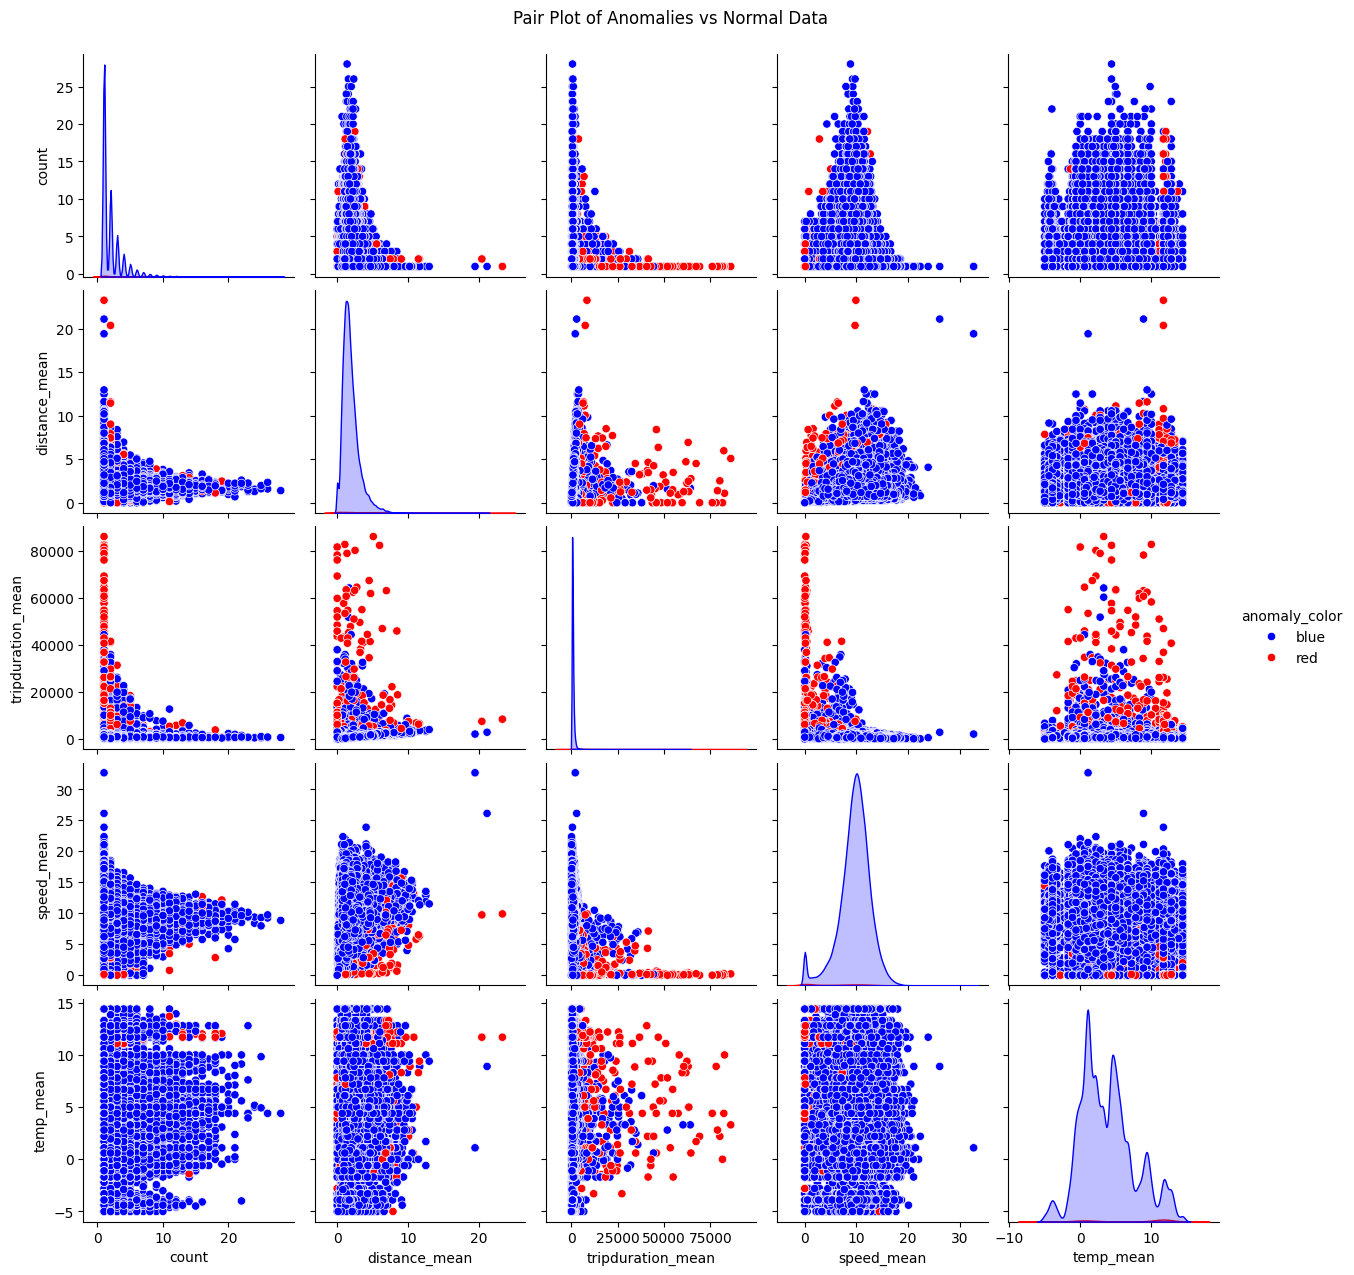

In [49]:
# Subset the data for pair plot visualization
features_for_pairplot = ['count', 'distance_mean', 'tripduration_mean', 'speed_mean', 'temp_mean']
station_data['anomaly_color'] = station_data['anomaly'].map({1: 'blue', -1: 'red'})

# Create pair plot with anomalies highlighted
sns.pairplot(station_data[features_for_pairplot + ['anomaly_color']], 
             hue='anomaly_color', palette={'blue': 'blue', 'red': 'red'})
plt.suptitle('Pair Plot of Anomalies vs Normal Data', y=1.02)
plt.show()

## Feature Distribution with Anomalies Highlighted

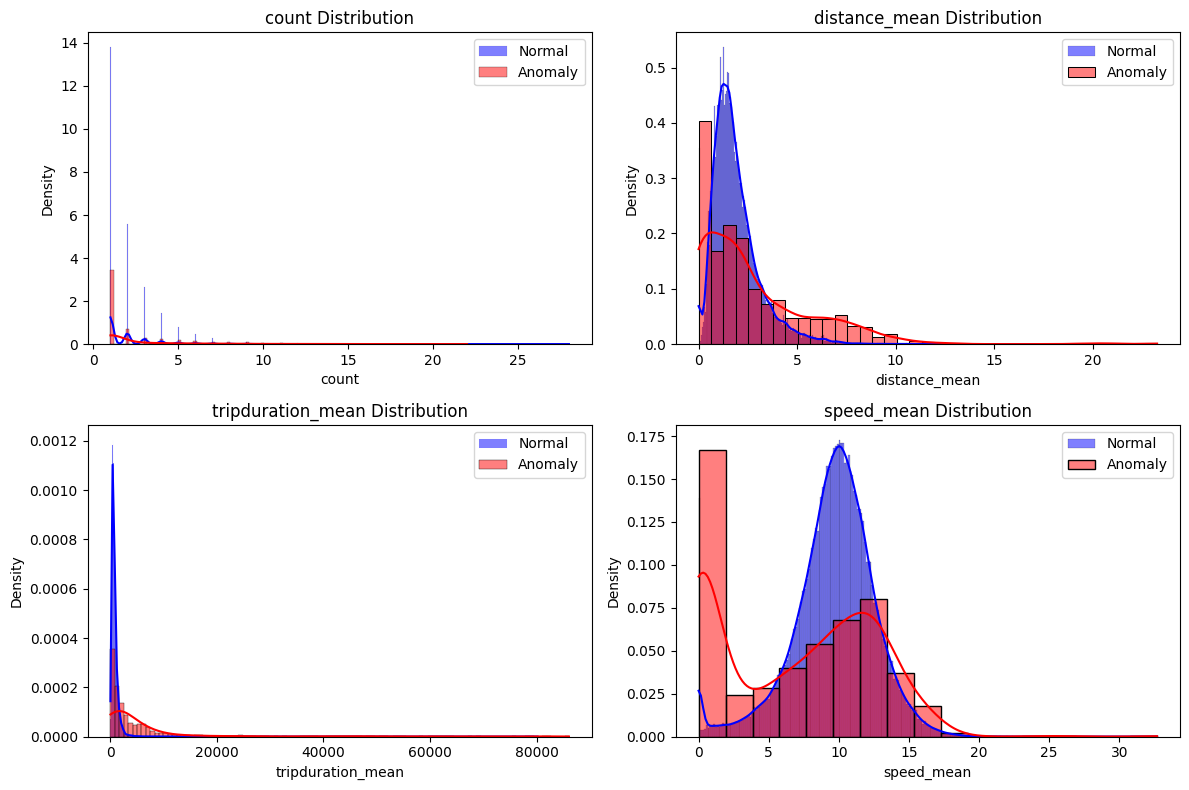

In [21]:
# Features to plot
features = ['count', 'distance_mean', 'tripduration_mean', 'speed_mean']

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(station_data[station_data['anomaly'] == 1][feature], color='blue', label='Normal', kde=True, stat='density', ax=axes[i])
    sns.histplot(station_data[station_data['anomaly'] == -1][feature], color='red', label='Anomaly', kde=True, stat='density', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution')
    axes[i].legend()

plt.tight_layout()
plt.show()

## Outlier Detection for Features

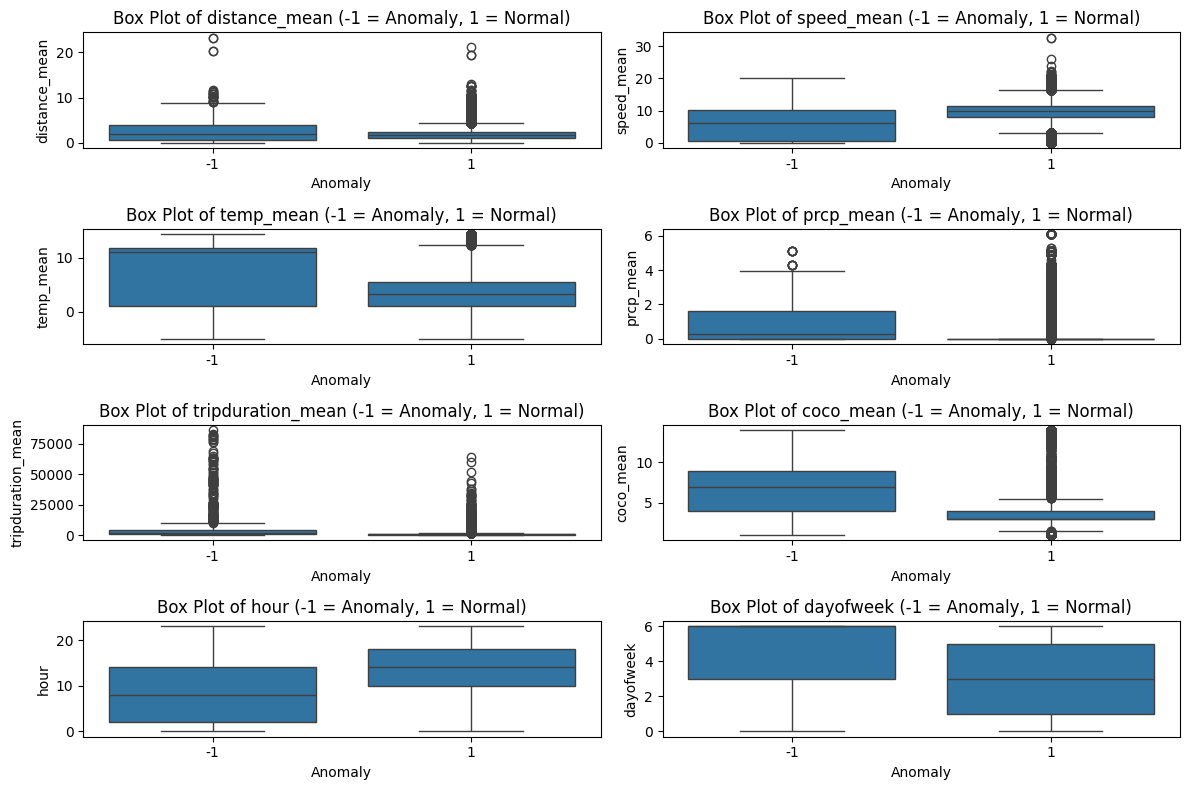

In [41]:
# Features to analyze
features = ['distance_mean', 'speed_mean', 'temp_mean', 'prcp_mean', 'tripduration_mean', 'coco_mean', 'hour', 'dayofweek']

# Box plots for normal data and anomalies
fig, axes = plt.subplots(4, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(data=station_data, x='anomaly', y=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature} (-1 = Anomaly, 1 = Normal)')
    axes[i].set_xlabel('Anomaly')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()


## Temporal Analysis (Line Plots Over Time)

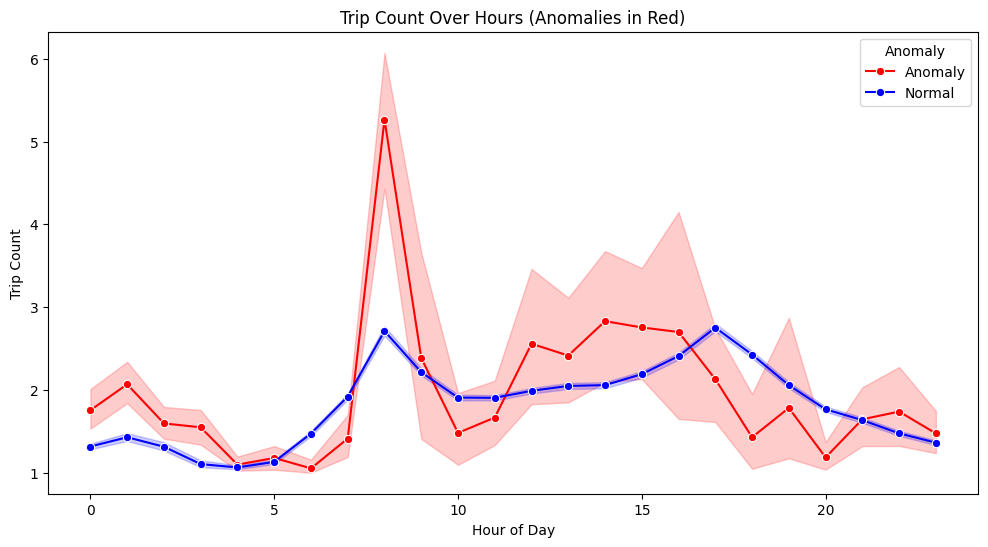

In [42]:
# Temporal visualization: Hour vs Trip Count
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=station_data, x='hour', y='count', hue='anomaly', 
             palette={1: 'blue', -1: 'red'}, marker='o')
plt.title('Trip Count Over Hours (Anomalies in Red)')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Anomaly", labels=["Anomaly", "Normal"])
plt.show()


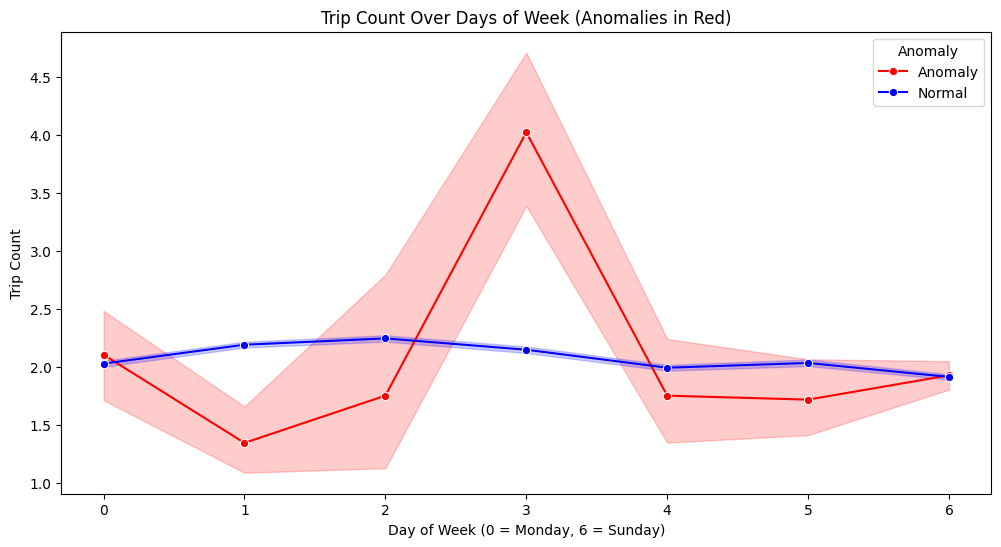

In [43]:
# Temporal Line Plot by Day of Week
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=station_data, x='dayofweek', y='count', hue='anomaly',
             palette={1: 'blue', -1: 'red'}, marker='o')
plt.title('Trip Count Over Days of Week (Anomalies in Red)')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Anomaly", labels=["Anomaly", "Normal"])
plt.show()

## Trends

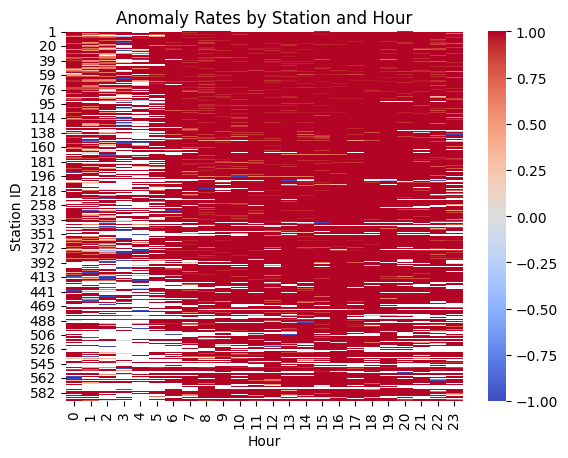

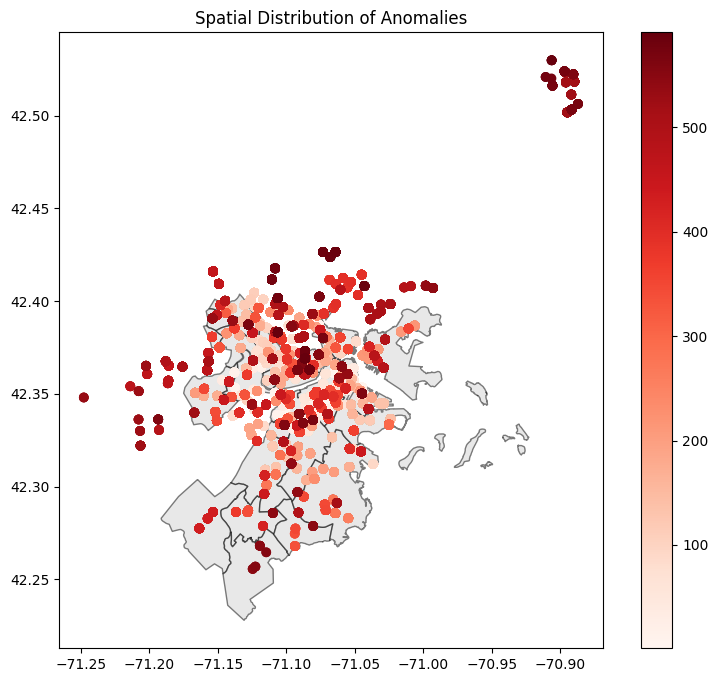

In [44]:
# Aggregate anomaly rates
anomaly_summary = station_data.groupby(['station_id', 'hour']).agg(
    anomaly_rate=('anomaly', 'mean'),
    count=('anomaly', 'size')
).reset_index()

# Heatmap
pivot_table = anomaly_summary.pivot_table(
    values='anomaly_rate',
    index='station_id',
    columns='hour'
)
sns.heatmap(pivot_table, cmap='coolwarm')
plt.title('Anomaly Rates by Station and Hour')
plt.xlabel('Hour')
plt.ylabel('Station ID')
plt.show()

# Spatial visualization
neighborhoods = gpd.read_file('../data/neighborhood_data/boston_cambridge_neighborhoods.geojson')
fig, ax = plt.subplots(figsize=(10, 8))

# Plot neighborhoods for context
neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

gdf = gpd.GeoDataFrame(station_data, geometry='geometry')
anomalies = gdf[gdf['anomaly'] == 1]
anomalies.plot(ax=ax, column='station_id', cmap='Reds', legend=True)
plt.title('Spatial Distribution of Anomalies')
plt.show()


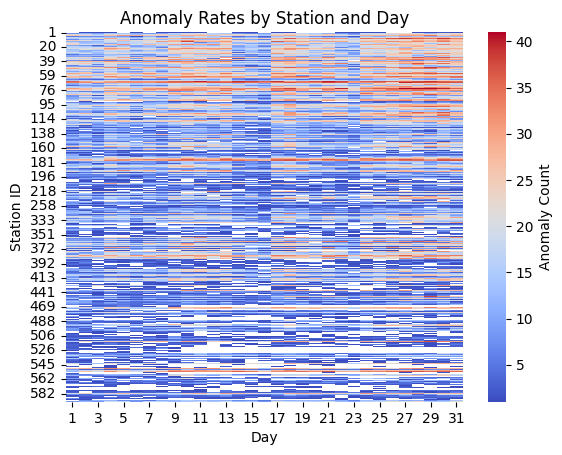

In [46]:
# Aggregate by day instead of hour
daywise_summary = station_data.groupby(['station_id', 'day']).agg(
    anomaly_rate=('anomaly', 'mean'),
    total_count=('anomaly', 'size')
).reset_index()

# Create a new heatmap
pivot_table = daywise_summary.pivot_table(
    values='total_count',
    index='station_id',
    columns='day'
)

sns.heatmap(pivot_table, cmap='coolwarm', cbar_kws={'label': 'Anomaly Count'})
plt.title('Anomaly Rates by Station and Day')
plt.xlabel('Day')
plt.ylabel('Station ID')
plt.show()


In [48]:
top_anomalous_stations = station_data.groupby('station_id')['anomaly'].size().nlargest(10)
print("Top 10 Anomalous Stations:")
print(top_anomalous_stations)


Top 10 Anomalous Stations:
station_id
67     1089
68     1063
74     1020
178    1004
179     987
554     957
46      943
60      939
55      931
380     926
Name: anomaly, dtype: int64


In [30]:
rush_hour_anomalies = station_data[station_data['hour'].isin([7, 8, 17, 18])].groupby('station_id')['anomaly'].mean()


In [31]:
weekend_anomalies = station_data[station_data['is_weekend'] == 1].groupby('station_id')['anomaly'].mean()
weekday_anomalies = station_data[station_data['is_weekend'] == 0].groupby('station_id')['anomaly'].mean()


In [34]:
rush_hour_anomalies

station_id
1      1.000000
3      0.968992
4      1.000000
6      0.958115
7      0.977273
         ...   
586    0.937500
587    0.888889
589    1.000000
590    1.000000
591    0.981308
Name: anomaly, Length: 372, dtype: float64